### Imports

In [1]:
# Remove unwanted warnings
import warnings

import numpy

warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Extraction and Management
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date as date
import requests
from io import StringIO
from dotenv import load_dotenv
import os

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Coinintegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Data Extraction

In [2]:
# Set data extraction parameters
start_date = '2017-01-01'
end_date = date.today()
load_dotenv()
FILE_PATH = os.getenv("FILE_PATH")
file_name = FILE_PATH + 'raw_data_etf.csv'
file_name_coint = FILE_PATH + 'raw_data_coint_pairs.csv'
load_existing = True
load_coint_pairs = True

In [3]:
# Get new or load existing data
# Allow 15 minutes for new data

# --- FUNCTION TO FETCH ETF SYMBOLS ---
def get_nasdaq_symbols():
    url = "https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to fetch NASDAQ symbol data")

    text = response.text
    lines = text.strip().splitlines()

    # Remove metadata line
    if lines[-1].startswith("File Creation Time"):
        lines = lines[:-1]

    data = pd.read_csv(
        StringIO("\n".join(lines)),
        sep="|",
        dtype=str
    )

    data.set_index("Symbol", inplace=True)
    return data


# --- MAIN LOGIC ---
if not load_existing:
    # Step 1: Get ETF symbols from Nasdaq
    symbols_df = get_nasdaq_symbols()
    symbols_df = symbols_df[
        (symbols_df["ETF"] == "Y") & (symbols_df["Market Category"] == "G")]  # Filter to Global Market ETFs
    symbols = list(symbols_df.index.values)

    print(f"Found {len(symbols)} ETF symbols. Downloading data...")

    # Step 2: Download data from Yahoo Finance using yfinance
    data = yf.download(
        tickers=symbols,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True,  # Prices are already adjusted, no need for 'Adj Close'
        threads=True
    )

    # Step 3: Extract just the adjusted close prices (from 'Close' column)
    adj_close = data.xs('Close', level=1, axis=1)

    # Step 4: Save to CSV
    adj_close.to_csv(file_name)
    print(f"Saved 'Close' prices to {file_name}")
    print(adj_close)

In [4]:
# Load (or reload for consistency) Data and remove features with NaN's
data = pd.read_csv(file_name, index_col=0)
data.dropna(axis=1, inplace=True)
data = data.reindex(sorted(data.columns), axis=1)
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (2174, 247)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,37.601696,47.405464,50.774803,32.197735,14.329916,17.356270,39.176502,23.363337,7.612016,18.377136,...,90.816483,38.323074,105.722954,48.657185,88.752045,50.763374,35.907982,39.851288,46.249332,24.865911
2017-01-04,38.248890,47.875500,51.209072,32.555576,14.329916,17.395885,39.385818,23.707903,7.719013,18.434368,...,91.860275,38.338654,107.942619,49.386963,90.094833,50.965645,36.304276,40.255379,46.661812,25.189087
2017-01-05,38.659107,48.550644,51.404915,32.833893,14.329916,17.392286,39.871433,23.305418,7.776588,18.478903,...,91.693611,38.385433,107.111427,48.894474,88.880333,51.291878,36.576248,40.645535,46.627445,25.272188
2017-01-06,38.531490,48.311356,51.413429,32.698708,14.329916,17.377882,39.703983,23.305418,7.851485,18.497990,...,91.930435,38.323074,106.563606,48.688526,88.401390,51.148335,36.498547,40.429554,46.627445,25.318356
2017-01-09,38.668224,48.354088,51.294228,32.650997,14.329916,17.334661,39.812824,22.814569,7.801043,18.510717,...,91.614647,38.346451,106.497467,48.361694,87.332291,51.278831,36.428608,40.318081,46.326675,25.380222


# Feature Engineering

In [5]:
# Create DataFrame with Returns and Volatility Information
# 255 days = 255 trading days. Could be adjusted / changed to 365 for crypto if applying these techniques to cryptocurrency trading
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["returns"])
df_returns["volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,returns,volatility
AADR,0.118641,0.224776
AAXJ,0.091631,0.203803
ACWI,0.129350,0.177151
ACWX,0.094245,0.175565
AGNG,0.114132,0.174982


In [6]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,returns,volatility
AADR,0.272231,0.270696
AAXJ,-0.083260,0.047583
ACWI,0.413172,-0.235942
ACWX,-0.048848,-0.252813
AGNG,0.212890,-0.259015


# K-Means Clustering

In [7]:
# Find the Optimum Number of Clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kl.elbow
print(f"Optimum Clusters: {c}")

Optimum Clusters: 6


In [8]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

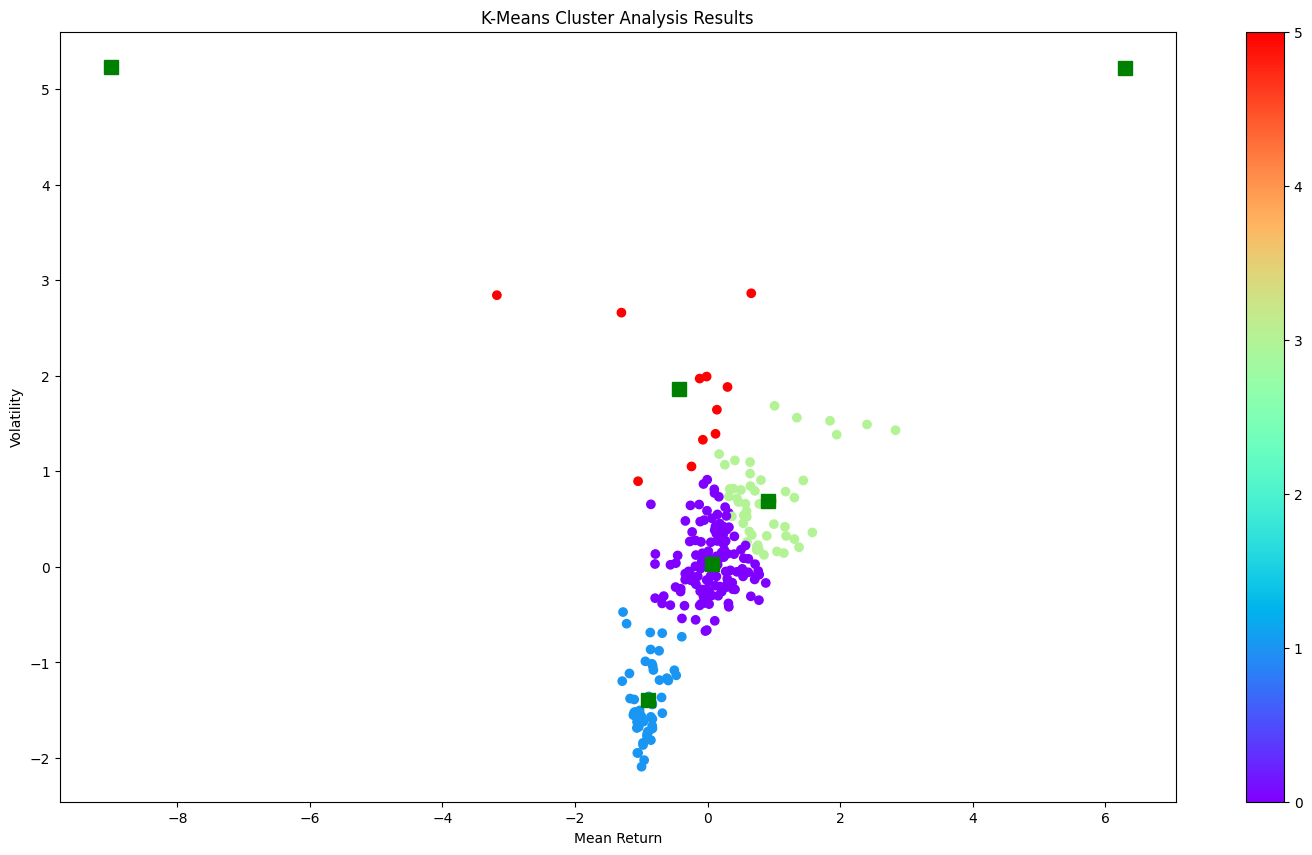

In [9]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18, 10))
axis = fig.add_subplot(111)
scatter = axis.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap="rainbow", label=X.index)
axis.set_title("K-Means Cluster Analysis Results")
axis.set_xlabel("Mean Return")
axis.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=10)

In [10]:
# Return the Series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

AADR    0
AAXJ    0
ACWI    0
ACWX    0
AGNG    0
AGZD    1
AIA     0
dtype: int32

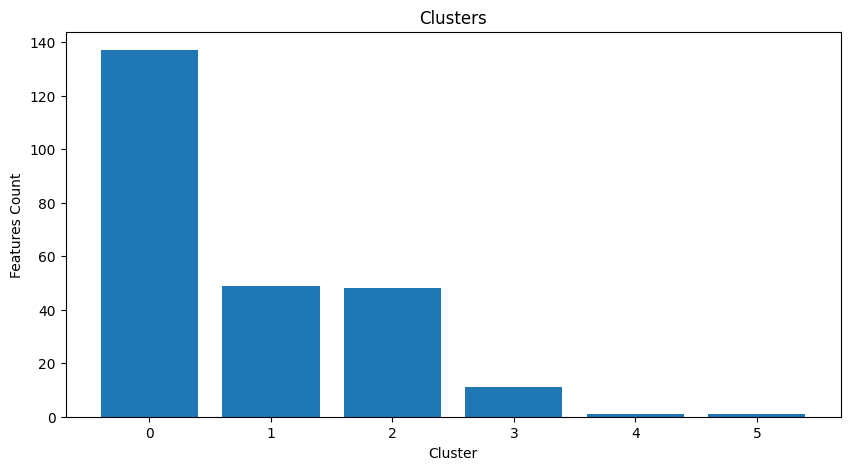

In [11]:
# View Number by Cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [12]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 3]
print(f"Feature Number Previous: {len(clustered_series)}")
print(f"Feature Number Current: {len(clusters_clean)}")

Feature Number Previous: 247
Feature Number Current: 187


# Calculate Cointegration

In [13]:
# Calculate Cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_result = coint(series_1, series_2)
    coint_test_result = coint_result[0]
    p_value = coint_result[1]
    critical_value = coint_result[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_test_result < critical_value else 0
    return coint_flag, hedge_ratio

In [14]:
# Loop through and calculate cointegrated pairs - Allow 15 - 30 minutes for calculation
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]

        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]

            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            if compare_asset != base_asset and base_label == compare_label and not is_tested:

                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset,
                                               "compare_asset": compare_asset,
                                               "label": base_label})

    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by=['label'])
    df_coint.to_csv(file_name_coint)

In [18]:
# Load Cointegrated Pairs
df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head()

,base_asset,compare_asset,label
385,IEI,IUSB,1
386,SLQD,VGSH,1
387,HYLS,HYXF,1
388,EMCB,SHY,1
389,EMCB,ISTB,1
390,HYXF,SLQD,1
391,GNMA,VMBS,1
392,HYLS,SLQD,1
393,HYLS,SHY,1
394,HYLS,IGSB,1


# TSNE Plot for Visualization

In [20]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values, df_coint["compare_asset"].values]
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AAXJ', 'ACWI', 'ACWX', 'AGNG', 'AGZD'], dtype=object)

In [23]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,returns,volatility
AAXJ,-0.083260,0.047583
ACWI,0.413172,-0.235942
ACWX,-0.048848,-0.252813
AGNG,0.212890,-0.259015
AGZD,-0.891405,-1.719766


In [24]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[  2.4149532,  -8.868877 ],
       [ 35.5473   ,  13.785614 ],
       [  8.679259 ,  19.383743 ],
       [ 26.588879 ,  14.416807 ],
       [-51.001305 ,  -3.7261007]], dtype=float32)

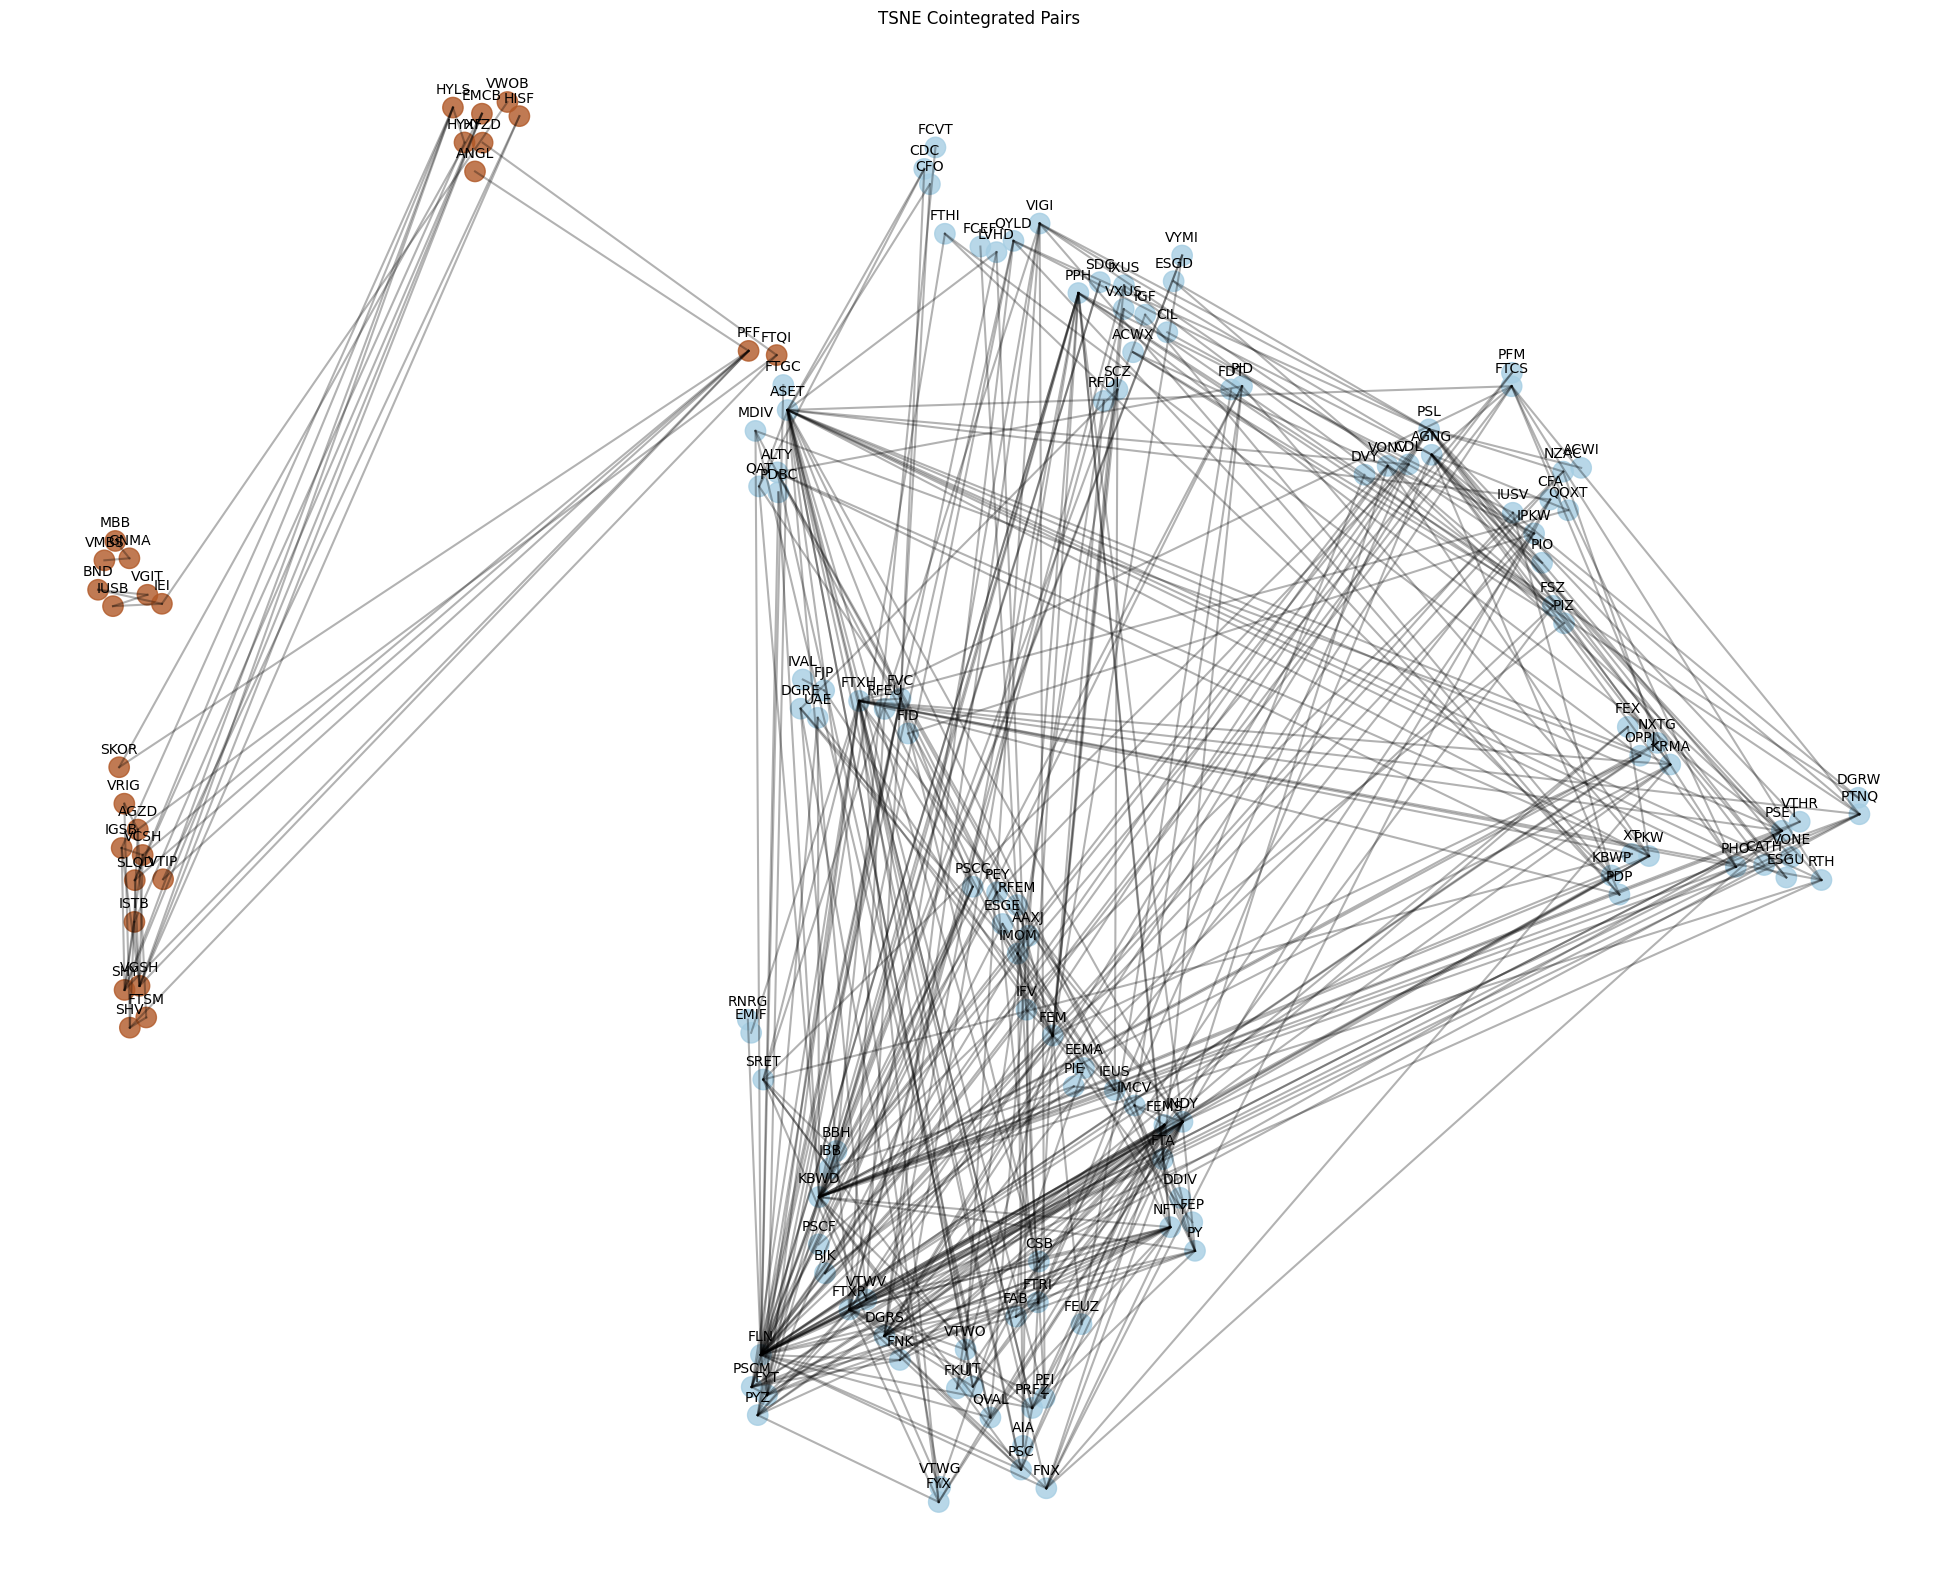

In [34]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc_1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc_1, :]
    ticker2 = pair[0]
    loc_2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc_2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap="Paired")
plt.title("TSNE Cointegrated Pairs")

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label=label, xy=(x, y), xytext=(0, 10), textcoords="offset points", ha="center", text="{}".format(label))